# Overview

A simple vanilla RNN implementation of a Shakespeare generator with pyTorch. The generator is trained character by character, using a single layer GRU unit. 

### Surprises

1. The LSTM and GRU units in pyTorch assumes full back-propagation through time (BPTT) length as the sequence that is fed in. AKA there is no need to loop in python to have the BPTT properly.

    A side effect of this is that the BPTT is the same as the sequence length, therefore long sequences are going to grow linearly in forward and backward compute time, which is nothing out of ordinary.
    
    **TLDR;**: If you were implementing vanilla RNN and was manually looping to get BPTT, don't worry here. torch GRU and LSTM already does that, and the time_steps is the same as the sequence length.
    
2. **It turned out the temperature in the self-feeding generator is crucial.**

    **What went wrong the first time**: 
    
    It turned out that the network itself was training okay. It was just that the generator was using an `argmax` for the next character selection, instead of doing a multinominal selection w.r.t. to the weights given by the softmax. 
    
    Effectively, `argmax` is equivalent to the Boltzmann distribution taken to the limit where $T\rightarrow 0$
    $$
    \mathrm{argmax}\bigg[\mathrm{softmax}@Y_{output} \bigg] \equiv \frac 1 Z \cdot e^{y_i/k_\beta T} 
    \bigg\vert_{T\rightarrow 0}.
    $$
    In this limit, the distribution is effectively frozen, and the state with the largest energy always gets picked. As it turned out, the character with the highest activation is not necessarily the best choice. Using a temperature ($k_\beta T$) gives much better result.
    
    Temperatures anywhere from 0.01 to 1 works well. The higher temperature gives a more garbled result, while the lower temerpature tend to quickly enter short repetive sentences.
    
    Now with the benefit of hind-sight, it is easy to understand why. The training is done using `softmax`
    $$
    \mathrm{softmax}:= e^{yi} \equiv \frac 1 Z \cdot e^{y_i/k_\beta T}\bigg\vert_{k_\beta T\rightarrow 1}.
    $$ 
    And as a result, the network is expected to hit whatever prediction accuracy when the output is a multinomial draw over this distribution. Althought the sampling mechanism can be different during the generative stage, large deviations from this limit will lead to very different results those during training.


### Todo:
all done

### Done:
- [x] Add temperature to generator
- [x] get training to work
- [x] use optim and Adam
- [x] add self-feeding generator

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from utils import forward_tracer, backward_tracer, Char2Vec, num_flat_features

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

from tqdm import tqdm

from IPython.display import clear_output

In [2]:
source = "";
with open('./data/shakespeare.txt', 'r') as f:
    for line in f:
        source += line + "\n"
        
source +=" " * 606
print([source[:60]])
len(source)

['First Citizen:\n\nBefore we proceed any further, hear me speak']


1156000

In [3]:
class GruRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, layers=1):
        super(GruRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.layers = layers
        
        self.encoder = nn.Linear(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, self.layers)
        self.decoder = nn.Linear(hidden_size, output_size)
        self.softmax = F.softmax
        
    def forward(self, x, hidden):
        embeded = self.encoder(x)
        #print(embeded.view(-1, 1, self.input_size).size())
        gru_output, hidden = self.gru(embeded.view(-1, 1, self.input_size), hidden.view(self.layers, 1, -1))
        #print(gru_output.size())
        output = self.decoder(gru_output.view(-1, self.output_size))
        return output, hidden
    
    def init_hidden(self, random=False):
        if random:
            return Variable(torch.randn(layers, hidden_size))
        else:
            return Variable(torch.zeros(layers, hidden_size)) 
"""
input_size = 101
hidden_size = 101
output_size = 101
layers = 2

gRNN = GruRNN(input_size, hidden_size, output_size, layers)

gRNN(Variable(torch.FloatTensor(10000, 101)),
     Variable(torch.FloatTensor(layers, 101)))"""

'\ninput_size = 101\nhidden_size = 101\noutput_size = 101\nlayers = 2\n\ngRNN = GruRNN(input_size, hidden_size, output_size, layers)\n\ngRNN(Variable(torch.FloatTensor(10000, 101)),\n     Variable(torch.FloatTensor(layers, 101)))'

In [4]:
class Shakespeare():
    def __init__(self, model):
        self.model = model
        self.char2vec = Char2Vec()
        self.loss = 0
        self.losses = []
    
    def init_hidden_(self, random=False):
        self.hidden = model.init_hidden(random)
        return self
    
    def save(self, fn="GRU_Shakespeare.tar"):
        torch.save({
            "hidden": self.hidden, 
            "state_dict": model.state_dict(),
            "losses": self.losses
                   }, fn)
    
    def load(self, fn):
        checkpoint = torch.load(fn)
        self.hidden = checkpoint['hidden']
        model.load_state_dict(checkpoint['state_dict'])
        self.losses = checkpoint['losses']
    
    def setup_training(self, learning_rate):
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        self.loss_fn = nn.CrossEntropyLoss()
        self.init_hidden_()
        
    def reset_loss(self):
        self.loss = 0
        
    def forward(self, input_text, target_text):
        
        self.hidden = self.hidden.detach()
        
        self.optimizer.zero_grad()
        self.next_(input_text)
        target_vec = Variable(self.char2vec.char_code(target_text))
        self.loss += self.loss_fn(self.output, target_vec)
        
    def descent(self):
        self.loss.backward()
        self.optimizer.step()
        self.losses.append(self.loss.cpu().data.numpy())
        self.reset_loss()
    
    def embed(self, input_data):
        self.embeded = Variable(self.char2vec.one_hot(input_data))
        return self.embeded
        
    def next_(self, input_text):
        self.output, self.hidden = self.model(self.embed(input_text), self.hidden)
        return self
    
    def softmax_(self, temperature=0.5):
        self.softmax = self.model.softmax(self.output/temperature)
        return self
    
    def text(self, start=None, end=None):
        indeces = torch.multinomial(self.softmax[start:end]).view(-1)
        return self.char2vec.vec2str(indeces)

In [5]:
input_size = 100 # len(char2vec.chars)
hidden_size = input_size
layers = 1

model = GruRNN(input_size, hidden_size, input_size, layers=layers)
william = Shakespeare(model)
william.load('./data/Gru_Shakespeare.tar')

In [6]:
learning_rate = 2e-3
william.setup_training(learning_rate)

Epoch 39


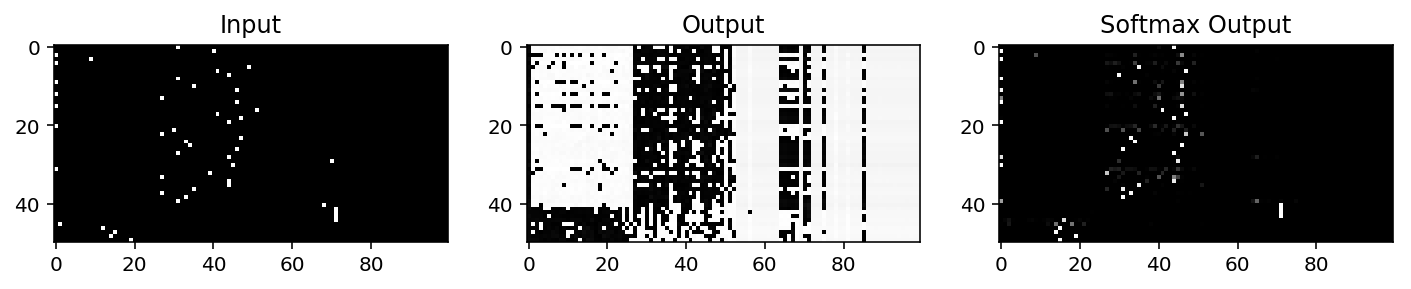

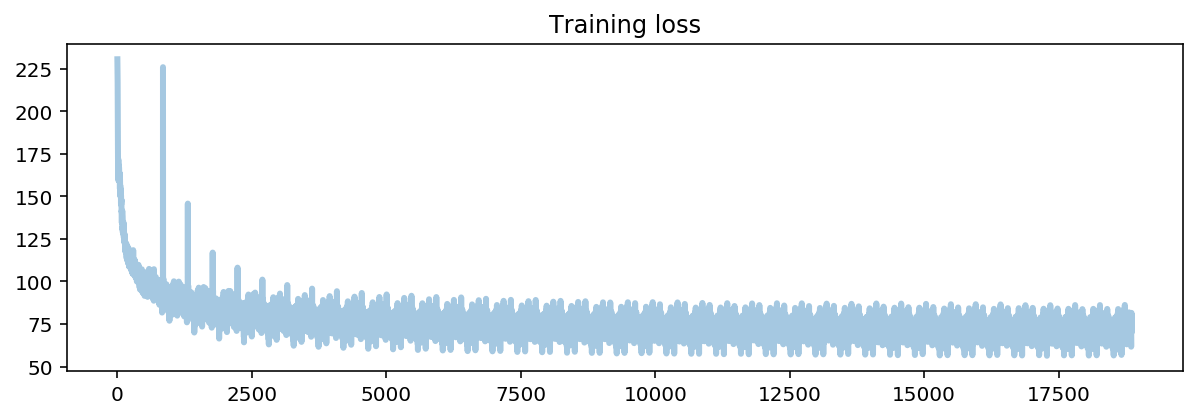

100%|█████████▉| 23010/23120 [06:58<00:03, 28.35it/s]

r t siud tn w  mour fryghter s barriege!



PRONSO


100%|██████████| 23120/23120 [07:00<00:00, 55.04it/s]


In [ ]:
model.zero_grad()
william.reset_loss()

seq_length = 50
batches = int(len(source)/seq_length)

for epoch_num in range(40):
    
    for step in tqdm(range(batches)):

        source_ = source[step*seq_length:(step+1)*seq_length]
        
        william.forward(source_, source_[1:] + " ")
        #william.descent()
        
        if step%50 == 49:
            william.descent()
        
        if step%1000 == 999:
            clear_output(wait=True)
            print('Epoch {:d}'.format(epoch_num))

            william.softmax_()

            plt.figure(figsize=(12, 9))
            plt.subplot(131)
            plt.title("Input")
            plt.imshow(william.embeded[:130].data.byte().numpy(), cmap="Greys_r", interpolation="none")
            plt.subplot(132)
            plt.title("Output")
            plt.imshow(william.output[:130].data.byte().numpy(), cmap="Greys_r", interpolation="none")
            plt.subplot(133)
            plt.title("Softmax Output")
            plt.imshow(william.softmax[:130].cpu().data.numpy(), cmap="Greys_r", interpolation="none")
            plt.show()
            
            plt.figure(figsize=(10, 3))
            plt.title('Training loss')
            plt.plot(william.losses, label="loss", linewidth=3, alpha=0.4)
            plt.show()

            print(william.text(0,150))

## Now use the network to generate text!

In [15]:
# william.save('./data/Gru_Shakespeare.tar')

In [7]:
from ipywidgets import widgets
from IPython.display import display

uaaiu!


The company of the sea the master of the seas

And sir, the prison the court the court the seas the seas

And see the crown the princess of the master of the

stark the master that thou art 


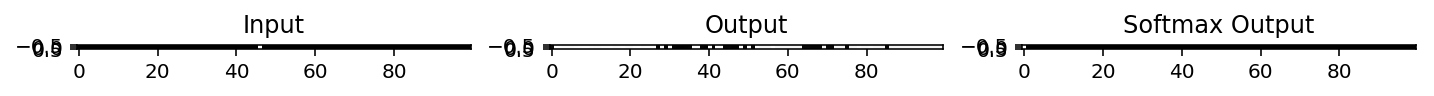

In [8]:
def predict_next(input_text, gen_length=None, temperature=0.05):
    
    if gen_length is None: 
        gen_length = len(input_text)
    
    clear_output(wait=True)
    william = Shakespeare(model).init_hidden_(random=True)
    
    william.next_(input_text)
    william.softmax_()
    string_output = william.text()
        
    for i in range(1, gen_length - len(input_text)):
        last_char = string_output[-1]
        william.next_(last_char)
        william.softmax_(temperature)
        string_output += william.text()
    
    print(string_output)
    
    plt.figure(figsize=(12, 9))
    plt.subplot(131)
    plt.title("Input")
    plt.imshow(william.embeded[:130].data.byte().numpy(), cmap="Greys_r", interpolation="none")
    plt.subplot(132)
    plt.title("Output")
    plt.imshow(william.output[:130].data.byte().numpy(), cmap="Greys_r", interpolation="none")
    plt.subplot(133)
    plt.title("Softmax Output")
    plt.imshow(william.softmax[:130].cpu().data.numpy(), cmap="Greys_r", interpolation="none")
    plt.show()

predict_next("Ge Yang:\n", 200)

&XA:A:::XnNH GZN &LCN::
&r

Ed and sir, the privil the life and such my will,

As thou not is the such a dangers and born a deserve

The hand with a kind straight the body

And she word the track thee to lo is a man the suits

The beauting of the children! stay the prison.



PROSPERO:

Sir, so say and deadly cold and good good cannot three

To make my father's begon his graced this hand

The dunted this like a man in the talk.



PROSPERO:

Sir, the court and all the bourself on my love.

What sir, that in the comes of this man and lives.



MIRANDA:

Why, what make thee strease the most father to me a son

To see the for the man the both of my thing

To compari shall not since the pleasure and ribot:

And every married must thee best both this soul;

Thou art rest the brother from the presents and boot

And the mad of all the sea with him in the content.



PROSPERO:

I am men must as in the mad to the day,

And friends and makes the sing and sir me that come of

And married and the 

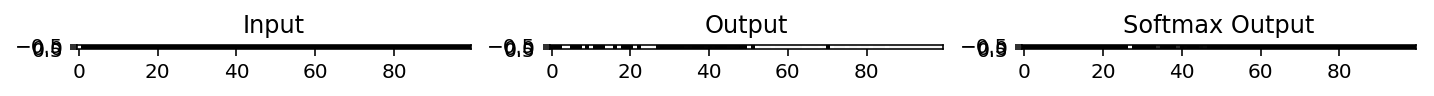

In [13]:
text_input = widgets.Text()
display(text_input)

def handle_submit(sender):
    #print(text_input.value)
    predict_next(text_input.value, 2000, temperature=0.5)
    
text_input.on_submit(handle_submit)

The prediction is okay...😅